In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import gc
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from IPython.display import display
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True, precision=3)
pd.set_option("display.float_format", "{:.3f}".format)

Set gpu

In [2]:
device = 'cpu'
try:
    import torch
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
except:
    pass
print(f"Running models on device: {device}")

Running models on device: cuda:0


Variables dataframe, sort by end of month

In [3]:
DATASET = "High_quality_2019.csv"

variables_df = (
    pd.read_csv(f'{DATASET}', low_memory=True)
    .sort_values(by=['eom'])
    .reset_index(drop=True)
)
print(variables_df.memory_usage(deep=True).sum())

16545807


All columns are float64 ,aprox 15 mB usage

In [4]:
variables_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24225 entries, 0 to 24224
Data columns (total 78 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 24225 non-null  float64
 1   eom                24225 non-null  object 
 2   dolvol             24225 non-null  float64
 3   ret_exc_lead1m     24225 non-null  float64
 4   enterprise_value   24225 non-null  float64
 5   chcsho_1m          24225 non-null  float64
 6   chcsho_3m          24225 non-null  float64
 7   chcsho_6m          24225 non-null  float64
 8   eqnpo_1m           24225 non-null  float64
 9   eqnpo_3m           24225 non-null  float64
 10  eqnpo_6m           24225 non-null  float64
 11  ret_1_0            24225 non-null  float64
 12  ret_2_0            24225 non-null  float64
 13  ret_3_0            24225 non-null  float64
 14  ret_3_1            24225 non-null  float64
 15  ret_6_0            24225 non-null  float64
 16  ret_6_1            242

New mem usage is 4 mb

In [5]:
SEED = 42
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    # change eom to datetime in format YYYY-MM-DD
    df['eom'] = pd.to_datetime(df['eom'], format='%Y-%m-%d')
    # change age and id to int
    df['age'] = df['age'].fillna(0).astype(np.int16)
    df['id'] = df['id'].astype(np.int32)
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != 'datetime64[ns]':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

print(reduce_mem_usage(variables_df))

Mem. usage decreased to  3.93 Mb (72.8% reduction)
              id        eom        dolvol  ret_exc_lead1m  enterprise_value  \
0      321304001 2001-01-31   1823558.375           0.029           154.697   
1      310345401 2001-01-31    324680.969          -0.000            26.079   
2      310367601 2001-01-31    361265.844          -0.079           233.262   
3      310507101 2001-01-31   1329782.125          -0.091           694.904   
4      320178201 2001-01-31    167096.812          -0.071            47.238   
...          ...        ...           ...             ...               ...   
24220  321303501 2019-12-31  16172783.000           0.015           428.816   
24221  321302901 2019-12-31 806729856.000          -0.057         29376.215   
24222  321146301 2019-12-31  10988884.000          -0.004          1060.295   
24223  322175102 2019-12-31  29369480.000          -0.026          2769.699   
24224  332964101 2019-12-31    678412.062          -0.129            31.132   



All variables of the data are float

In [6]:
variables_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24225 entries, 0 to 24224
Data columns (total 78 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 24225 non-null  int32         
 1   eom                24225 non-null  datetime64[ns]
 2   dolvol             24225 non-null  float32       
 3   ret_exc_lead1m     24225 non-null  float16       
 4   enterprise_value   24225 non-null  float32       
 5   chcsho_1m          24225 non-null  float16       
 6   chcsho_3m          24225 non-null  float16       
 7   chcsho_6m          24225 non-null  float16       
 8   eqnpo_1m           24225 non-null  float16       
 9   eqnpo_3m           24225 non-null  float16       
 10  eqnpo_6m           24225 non-null  float16       
 11  ret_1_0            24225 non-null  float16       
 12  ret_2_0            24225 non-null  float16       
 13  ret_3_0            24225 non-null  float16       
 14  ret_3_

There not exists null values

In [7]:
variables_df.isnull().sum()

id                  0
eom                 0
dolvol              0
ret_exc_lead1m      0
enterprise_value    0
                   ..
bidaskhl_21d        0
rvolhl_21d          0
age                 0
qmj_prof            0
qmj_safety          0
Length: 78, dtype: int64

## **EDA**

Explore correlations, outliers, patterns in period times.

Next steps: Temporal feature engineering (exponential moving average, lags, rolls) based on the patterns period times. Dimensionality reduction (maybe yes, maybe not)

In [8]:
variables_df

,id,eom,dolvol,ret_exc_lead1m,enterprise_value,chcsho_1m,chcsho_3m,chcsho_6m,eqnpo_1m,eqnpo_3m,eqnpo_6m,ret_1_0,ret_2_0,ret_3_0,ret_3_1,ret_6_0,ret_6_1,ret_9_0,ret_9_1,ret_12_0,at_gr1,lt_gr1,cash_gr1a,fna_gr1a,fnl_gr1a,nfna_gr1a,ebitda_gr1a,ebit_gr1a,ni_gr1a,nix_gr1a,ocf_gr1a,ebitda_at,ebit_at,fi_at,ni_at,dbnetis_at,cash_lt,debt_at,at_turnover,cash_at,op_atl1,ocf_at,op_at,ocf_at_chg1,at_me,debt_me,netdebt_me,cash_me,sale_me,ebitda_me,ebit_me,ni_me,nix_me,ocf_me,at_mev,ebitda_mev,ebit_mev,ocf_mev,debt_mev,mispricing_mgmt,mispricing_perf,dolvol_126d,dolvol_var_126d,turnover_126d,turnover_var_126d,zero_trades_126d,zero_trades_252d,ami_126d,beta_252d,ivol_capm_252d,prc_highprc_252d,rvol_252d,betadown_252d,bidaskhl_21d,rvolhl_21d,age,qmj_prof,qmj_safety
0,321304001,2001-01-31,1823558.375,0.029,154.697,0.000,0.000,0.000,0.000,-0.000,-0.000,0.388,0.159,0.004,-0.277,0.257,-0.095,0.296,-0.066,-0.019,-0.158,0.180,-0.062,-0.028,0.146,-0.174,-0.338,-0.356,-0.303,-0.303,-0.124,-0.096,-0.184,-0.181,-0.200,0.000,0.140,0.396,1.554,0.095,-0.081,-0.046,-0.096,-0.111,1.195,0.474,0.361,0.113,2.033,-0.115,-0.220,-0.239,-0.239,-0.055,0.878,-0.085,-0.162,-0.041,0.348,0.523,0.312,99023.625,2.988,0.001,2.912,0.006,0.005,1.390,0.226,0.038,0.853,0.038,-0.105,0.014,0.051,205,-0.836,-1.378
1,310345401,2001-01-31,324680.969,-0.000,26.079,0.000,0.000,0.000,0.000,0.000,0.000,-0.031,-0.039,-0.053,-0.023,-0.222,-0.197,-0.213,-0.188,-0.155,-0.136,-0.430,-0.287,0.000,-0.317,0.155,0.033,0.037,0.022,0.022,0.066,0.177,0.128,0.089,0.067,-0.303,0.409,0.176,1.265,0.182,0.127,0.155,0.177,0.091,2.104,0.357,-0.013,0.369,3.070,0.358,0.259,0.135,0.135,0.315,2.051,0.363,0.262,0.319,0.361,0.716,0.623,43499.535,4.320,0.001,4.129,0.005,0.004,5.914,0.222,0.041,0.680,0.042,0.401,0.011,0.006,205,1.553,0.271
2,310367601,2001-01-31,361265.844,-0.079,233.262,0.000,0.000,0.000,-0.000,-0.000,0.000,0.015,-0.125,-0.132,-0.145,-0.319,-0.329,-0.259,-0.270,-0.452,0.608,0.701,-0.061,-0.019,0.202,-0.222,-0.043,-0.058,-0.066,-0.066,-0.045,0.034,-0.010,-0.003,-0.022,0.287,0.182,0.334,1.043,0.090,0.055,-0.017,0.034,-0.062,7.402,2.471,1.805,0.666,5.777,0.232,-0.071,-0.148,-0.148,-0.115,2.641,0.067,-0.021,-0.033,0.881,0.304,0.327,79272.641,3.002,0.001,3.393,0.007,0.005,3.994,0.712,0.031,0.530,0.033,0.942,0.018,0.013,205,-0.889,-1.455
3,310507101,2001-01-31,1329782.125,-0.091,694.904,0.000,0.000,0.000,0.000,0.000,0.000,-0.009,0.067,-0.049,-0.040,0.018,0.027,0.014,0.024,-0.185,-0.096,-0.244,0.001,0.002,-0.143,0.145,-0.029,-0.030,0.035,0.035,0.005,0.069,0.023,0.076,0.058,-0.074,0.079,0.217,0.996,0.046,0.063,0.040,0.069,0.008,12.352,2.676,2.113,0.563,12.680,0.838,0.281,0.696,0.696,0.483,3.967,0.363,0.122,0.209,0.860,0.617,0.437,241422.078,3.521,0.001,3.586,0.006,0.007,2.428,0.521,0.031,0.775,0.031,0.550,0.013,0.021,205,-0.013,-0.734
4,320178201,2001-01-31,167096.812,-0.071,47.238,0.000,0.000,0.000,0.000,-0.000,-0.000,0.012,0.091,0.066,0.054,-0.034,-0.046,-0.183,-0.193,-0.184,-0.126,-0.121,0.004,-0.000,-0.019,0.019,-0.040,-0.024,-0.023,-0.023,-0.017,0.095,0.032,0.029,0.013,0.010,0.065,0.232,0.927,0.036,0.083,0.082,0.095,-0.005,3.408,0.790,0.668,0.122,3.387,0.324,0.108,0.044,0.044,0.280,2.043,0.194,0.065,0.168,0.474,0.599,0.284,57029.668,4.688,0.002,4.547,0.004,0.005,4.223,0.272,0.034,0.737,0.034,0.185,0.010,0.009,205,-0.305,-0.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24220,321303501,2019-12-31,16172783.000,0.015,428.816,0.000,0.000,0.000,0.000,0.000,0.000,0.177,0.208,0.251,0.063,0.173,-0.003,0.268,0.078,0.287,0.054,-0.048,0.065,0.002,0.016,-0.013,0.090,0.072,0.038,0.040,0.082,0.184,0.124,0.079,0.074,-0.152,0.175,0.314,1.024,0.102,0.194,0.153,0.184,0.078,1.281,0.403,0.272,0.131,1.278,0.236,0.159,0.095,0.095,0.196,1.007,0.186,0.1

Identify outliers

In [9]:
## function to plot boxplot for each feature, and normalized them
z_scores = np.abs((variables_df.select_dtypes(include=[np.number]) - variables_df.mean()) / variables_df.std())
outlier_mask = (z_scores > 3)
outlier_summary = outlier_mask.sum().sort_values(ascending=False)/variables_df.select_dtypes(include=[np.number]).shape[0] * 100
outlier_summary.head(15)

at_mev              100.000
at_me               100.000
cash_at               3.418
dolvol_126d           2.456
turnover_var_126d     2.254
dolvol_var_126d       2.246
dolvol                2.167
ivol_capm_252d        1.775
rvolhl_21d            1.730
bidaskhl_21d          1.730
rvol_252d             1.688
ret_1_0               1.606
ret_2_0               1.552
ret_3_1               1.511
eqnpo_6m              1.486
dtype: float64

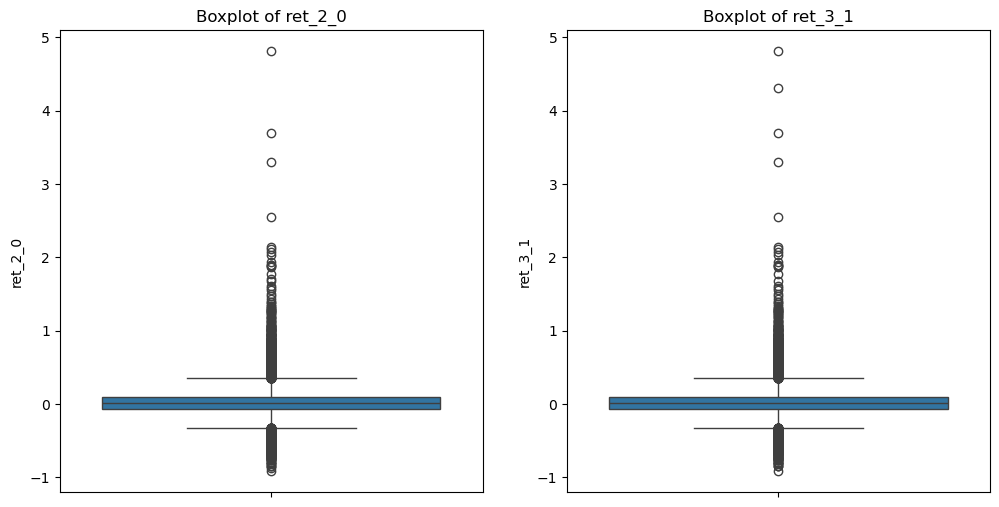

In [10]:
## boxplot at_mev and at_me, because it detects 100% of outliers
var1 = "ret_2_0"
var2 = "ret_3_1"
variables=[var1,var2]
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.boxplot(y=variables_df[variables[0]])
plt.title(f'Boxplot of {variables[0]}')
plt.subplot(1, 2, 2)
sns.boxplot(y=variables_df[variables[1]])
plt.title(f'Boxplot of {variables[1]}')
plt.show()

<Axes: >

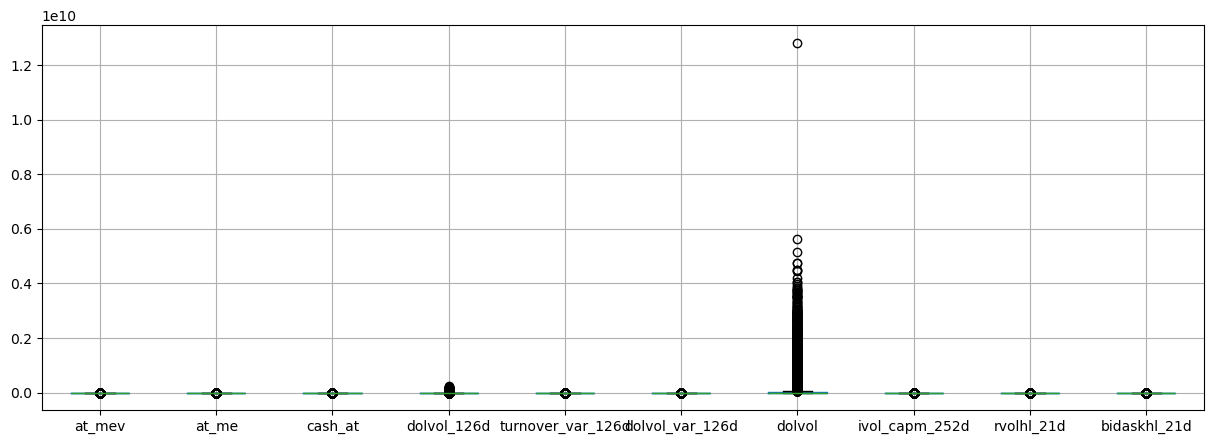

In [11]:
variables_df[outlier_summary.head(10).index].boxplot(figsize=(15,5))

Discard a subgroup of high correlation variables.  \

Hint: Just take one, and discard the other (by pairs)

In [12]:
corr = variables_df.corr(numeric_only=True)
corr_pairs = corr.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs != 1]  # quitar diagonales
corr_pairs.head(15)

fnl_gr1a           fi_at               0.995
fi_at              fnl_gr1a            0.995
netdebt_me         debt_me             0.994
debt_me            netdebt_me          0.994
rvol_252d          ivol_capm_252d      0.993
ivol_capm_252d     rvol_252d           0.993
nfna_gr1a          debt_at             0.991
debt_at            nfna_gr1a           0.991
dolvol_var_126d    turnover_var_126d   0.991
turnover_var_126d  dolvol_var_126d     0.991
ni_at              ni_gr1a             0.989
ni_gr1a            ni_at               0.989
ni_me              nix_me              0.987
nix_me             ni_me               0.987
debt_at            ni_gr1a             0.987
dtype: float64

Discard the four with most correlation

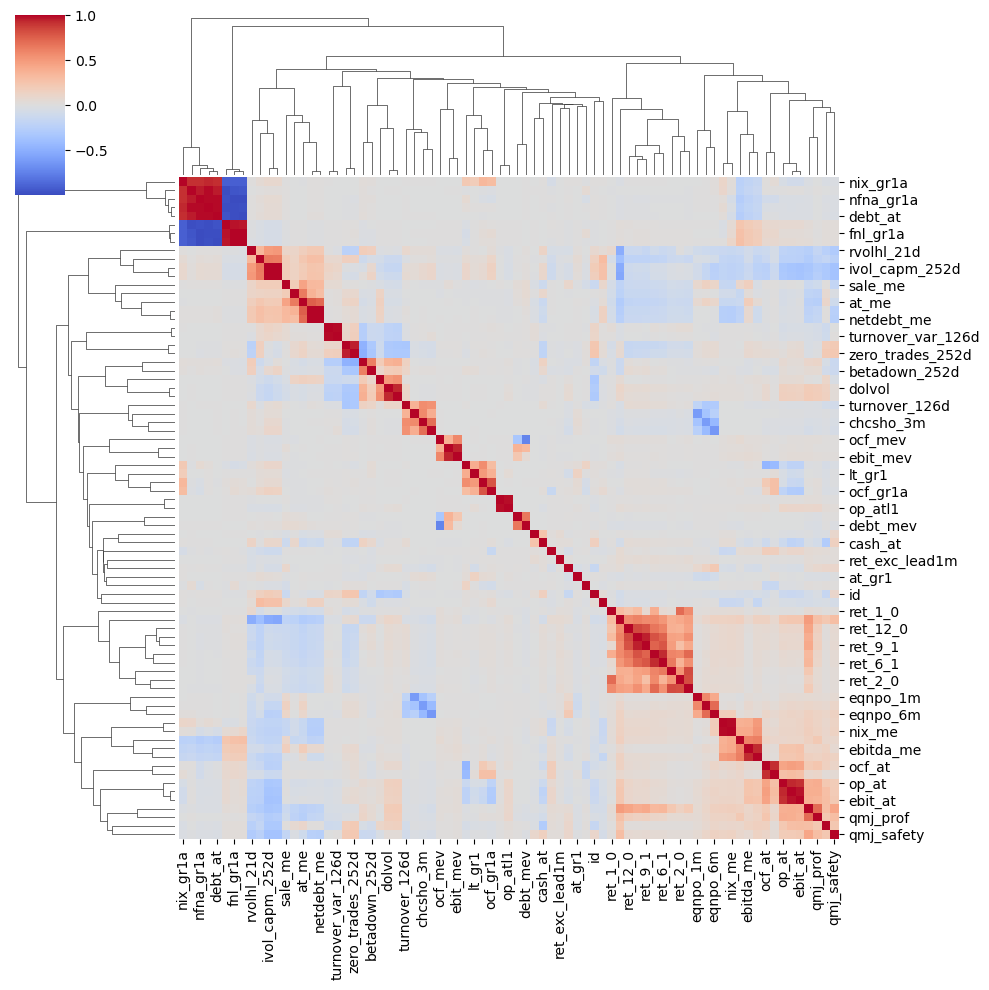

In [13]:
import seaborn as sns
sns.clustermap(corr, cmap='coolwarm', figsize=(10,10))

There are outliers on the target temporal series.

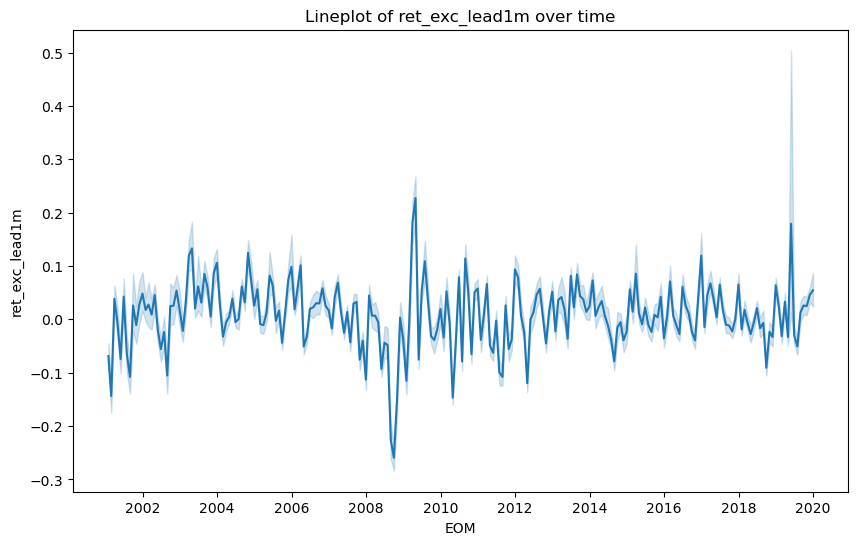

In [14]:
# lineplot de ret_exc_lead1m
plt.figure(figsize=(10,6))
sns.lineplot(data=variables_df, x='eom', y='ret_exc_lead1m')
plt.title('Lineplot of ret_exc_lead1m over time')
plt.xlabel('EOM')
plt.ylabel('ret_exc_lead1m')
plt.show()

Quitaremos la variable age, pues tiene una relación lineal muy fuerte con el target.

También nix_gr1a, nfna_gr1a, debt_at, fnl_gr1a, pues están altamente correlacionadas

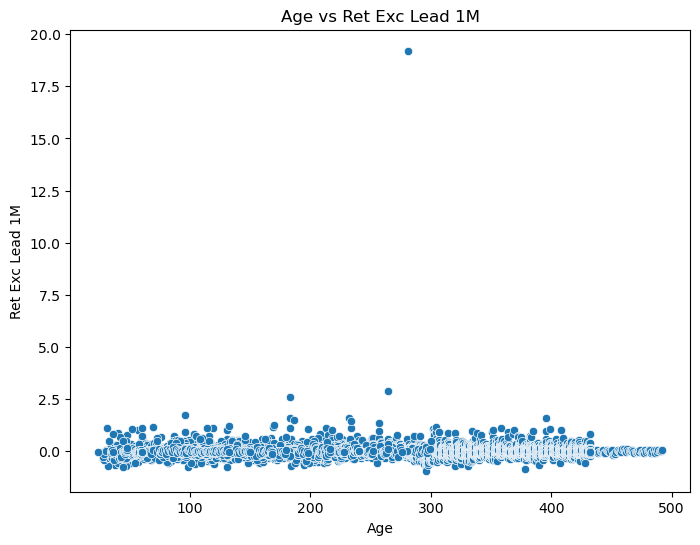

In [15]:
# age vs ret_exc_lead1m
plt.figure(figsize=(8,6))
sns.scatterplot(x='age', y='ret_exc_lead1m', data=variables_df)
plt.title('Age vs Ret Exc Lead 1M')
plt.xlabel('Age')
plt.ylabel('Ret Exc Lead 1M')
plt.show()

Bajarse columnas altamanete correlacionadas

In [16]:
variables_df

,id,eom,dolvol,ret_exc_lead1m,enterprise_value,chcsho_1m,chcsho_3m,chcsho_6m,eqnpo_1m,eqnpo_3m,eqnpo_6m,ret_1_0,ret_2_0,ret_3_0,ret_3_1,ret_6_0,ret_6_1,ret_9_0,ret_9_1,ret_12_0,at_gr1,lt_gr1,cash_gr1a,fna_gr1a,fnl_gr1a,nfna_gr1a,ebitda_gr1a,ebit_gr1a,ni_gr1a,nix_gr1a,ocf_gr1a,ebitda_at,ebit_at,fi_at,ni_at,dbnetis_at,cash_lt,debt_at,at_turnover,cash_at,op_atl1,ocf_at,op_at,ocf_at_chg1,at_me,debt_me,netdebt_me,cash_me,sale_me,ebitda_me,ebit_me,ni_me,nix_me,ocf_me,at_mev,ebitda_mev,ebit_mev,ocf_mev,debt_mev,mispricing_mgmt,mispricing_perf,dolvol_126d,dolvol_var_126d,turnover_126d,turnover_var_126d,zero_trades_126d,zero_trades_252d,ami_126d,beta_252d,ivol_capm_252d,prc_highprc_252d,rvol_252d,betadown_252d,bidaskhl_21d,rvolhl_21d,age,qmj_prof,qmj_safety
0,321304001,2001-01-31,1823558.375,0.029,154.697,0.000,0.000,0.000,0.000,-0.000,-0.000,0.388,0.159,0.004,-0.277,0.257,-0.095,0.296,-0.066,-0.019,-0.158,0.180,-0.062,-0.028,0.146,-0.174,-0.338,-0.356,-0.303,-0.303,-0.124,-0.096,-0.184,-0.181,-0.200,0.000,0.140,0.396,1.554,0.095,-0.081,-0.046,-0.096,-0.111,1.195,0.474,0.361,0.113,2.033,-0.115,-0.220,-0.239,-0.239,-0.055,0.878,-0.085,-0.162,-0.041,0.348,0.523,0.312,99023.625,2.988,0.001,2.912,0.006,0.005,1.390,0.226,0.038,0.853,0.038,-0.105,0.014,0.051,205,-0.836,-1.378
1,310345401,2001-01-31,324680.969,-0.000,26.079,0.000,0.000,0.000,0.000,0.000,0.000,-0.031,-0.039,-0.053,-0.023,-0.222,-0.197,-0.213,-0.188,-0.155,-0.136,-0.430,-0.287,0.000,-0.317,0.155,0.033,0.037,0.022,0.022,0.066,0.177,0.128,0.089,0.067,-0.303,0.409,0.176,1.265,0.182,0.127,0.155,0.177,0.091,2.104,0.357,-0.013,0.369,3.070,0.358,0.259,0.135,0.135,0.315,2.051,0.363,0.262,0.319,0.361,0.716,0.623,43499.535,4.320,0.001,4.129,0.005,0.004,5.914,0.222,0.041,0.680,0.042,0.401,0.011,0.006,205,1.553,0.271
2,310367601,2001-01-31,361265.844,-0.079,233.262,0.000,0.000,0.000,-0.000,-0.000,0.000,0.015,-0.125,-0.132,-0.145,-0.319,-0.329,-0.259,-0.270,-0.452,0.608,0.701,-0.061,-0.019,0.202,-0.222,-0.043,-0.058,-0.066,-0.066,-0.045,0.034,-0.010,-0.003,-0.022,0.287,0.182,0.334,1.043,0.090,0.055,-0.017,0.034,-0.062,7.402,2.471,1.805,0.666,5.777,0.232,-0.071,-0.148,-0.148,-0.115,2.641,0.067,-0.021,-0.033,0.881,0.304,0.327,79272.641,3.002,0.001,3.393,0.007,0.005,3.994,0.712,0.031,0.530,0.033,0.942,0.018,0.013,205,-0.889,-1.455
3,310507101,2001-01-31,1329782.125,-0.091,694.904,0.000,0.000,0.000,0.000,0.000,0.000,-0.009,0.067,-0.049,-0.040,0.018,0.027,0.014,0.024,-0.185,-0.096,-0.244,0.001,0.002,-0.143,0.145,-0.029,-0.030,0.035,0.035,0.005,0.069,0.023,0.076,0.058,-0.074,0.079,0.217,0.996,0.046,0.063,0.040,0.069,0.008,12.352,2.676,2.113,0.563,12.680,0.838,0.281,0.696,0.696,0.483,3.967,0.363,0.122,0.209,0.860,0.617,0.437,241422.078,3.521,0.001,3.586,0.006,0.007,2.428,0.521,0.031,0.775,0.031,0.550,0.013,0.021,205,-0.013,-0.734
4,320178201,2001-01-31,167096.812,-0.071,47.238,0.000,0.000,0.000,0.000,-0.000,-0.000,0.012,0.091,0.066,0.054,-0.034,-0.046,-0.183,-0.193,-0.184,-0.126,-0.121,0.004,-0.000,-0.019,0.019,-0.040,-0.024,-0.023,-0.023,-0.017,0.095,0.032,0.029,0.013,0.010,0.065,0.232,0.927,0.036,0.083,0.082,0.095,-0.005,3.408,0.790,0.668,0.122,3.387,0.324,0.108,0.044,0.044,0.280,2.043,0.194,0.065,0.168,0.474,0.599,0.284,57029.668,4.688,0.002,4.547,0.004,0.005,4.223,0.272,0.034,0.737,0.034,0.185,0.010,0.009,205,-0.305,-0.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24220,321303501,2019-12-31,16172783.000,0.015,428.816,0.000,0.000,0.000,0.000,0.000,0.000,0.177,0.208,0.251,0.063,0.173,-0.003,0.268,0.078,0.287,0.054,-0.048,0.065,0.002,0.016,-0.013,0.090,0.072,0.038,0.040,0.082,0.184,0.124,0.079,0.074,-0.152,0.175,0.314,1.024,0.102,0.194,0.153,0.184,0.078,1.281,0.403,0.272,0.131,1.278,0.236,0.159,0.095,0.095,0.196,1.007,0.186,0.1

In [17]:
variables_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24225 entries, 0 to 24224
Data columns (total 78 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 24225 non-null  int32         
 1   eom                24225 non-null  datetime64[ns]
 2   dolvol             24225 non-null  float32       
 3   ret_exc_lead1m     24225 non-null  float16       
 4   enterprise_value   24225 non-null  float32       
 5   chcsho_1m          24225 non-null  float16       
 6   chcsho_3m          24225 non-null  float16       
 7   chcsho_6m          24225 non-null  float16       
 8   eqnpo_1m           24225 non-null  float16       
 9   eqnpo_3m           24225 non-null  float16       
 10  eqnpo_6m           24225 non-null  float16       
 11  ret_1_0            24225 non-null  float16       
 12  ret_2_0            24225 non-null  float16       
 13  ret_3_0            24225 non-null  float16       
 14  ret_3_

## **TRAINING**

Cross validation by periods (Variation of Time Series split from scikit learn)


>>> Evaluando LightGBMRegressor (regression)
[LGB Fold 1] RMSE=0.13284 | MAE=0.09365 | R2=-0.004 | ρ=0.106 | IC=0.131 | SR(LS)=1.449
[LGB Fold 2] RMSE=0.12296 | MAE=0.08194 | R2=0.000 | ρ=0.074 | IC=0.097 | SR(LS)=1.552
[LGB Fold 3] RMSE=0.13898 | MAE=0.08191 | R2=-0.056 | ρ=-0.038 | IC=0.003 | SR(LS)=-0.390
[LGB Fold 4] RMSE=0.12759 | MAE=0.07546 | R2=0.041 | ρ=0.229 | IC=0.208 | SR(LS)=4.644
[LGB Fold 5] RMSE=0.13498 | MAE=0.07647 | R2=0.010 | ρ=0.105 | IC=0.104 | SR(LS)=3.129
[LGB Fold 6] RMSE=0.11888 | MAE=0.07467 | R2=-0.000 | ρ=0.121 | IC=0.023 | SR(LS)=2.395
[LGB Fold 7] RMSE=0.09698 | MAE=0.06095 | R2=-0.038 | ρ=0.021 | IC=0.079 | SR(LS)=-0.014
[LGB Fold 8] RMSE=0.09856 | MAE=0.06643 | R2=-0.005 | ρ=0.053 | IC=0.103 | SR(LS)=0.847


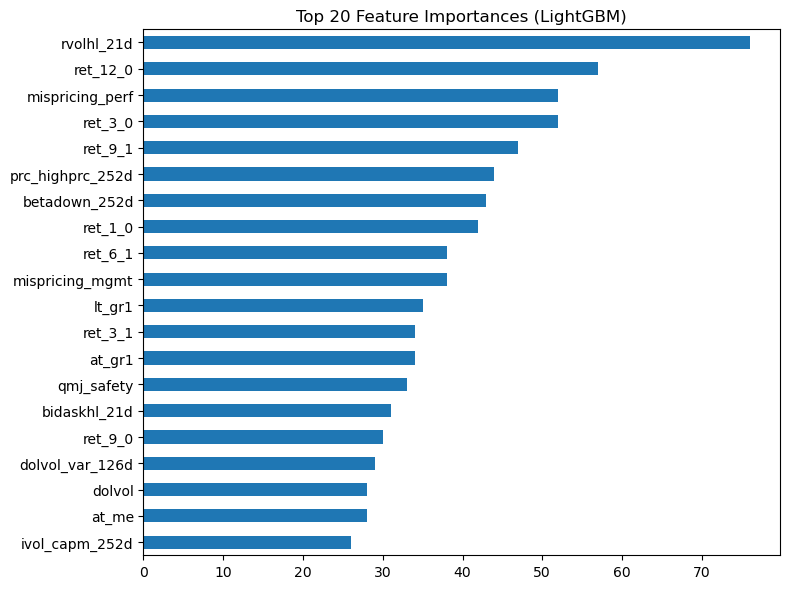


>>> Evaluando XGBRegressor (regression)
[XGB Fold 1] RMSE=0.13351 | MAE=0.09446 | R2=-0.014 | ρ=0.077 | IC=0.104 | SR(LS)=0.973
[XGB Fold 2] RMSE=0.12315 | MAE=0.08214 | R2=-0.003 | ρ=0.023 | IC=-0.004 | SR(LS)=1.899
[XGB Fold 3] RMSE=0.13809 | MAE=0.08109 | R2=-0.043 | ρ=0.060 | IC=0.056 | SR(LS)=2.079
[XGB Fold 4] RMSE=0.12713 | MAE=0.07572 | R2=0.048 | ρ=0.242 | IC=0.214 | SR(LS)=5.422
[XGB Fold 5] RMSE=0.13558 | MAE=0.07656 | R2=0.001 | ρ=0.062 | IC=0.069 | SR(LS)=1.975
[XGB Fold 6] RMSE=0.11868 | MAE=0.07489 | R2=0.003 | ρ=0.134 | IC=-0.025 | SR(LS)=1.537
[XGB Fold 7] RMSE=0.09725 | MAE=0.06135 | R2=-0.044 | ρ=-0.021 | IC=0.066 | SR(LS)=0.613
[XGB Fold 8] RMSE=0.09871 | MAE=0.06689 | R2=-0.008 | ρ=0.014 | IC=0.055 | SR(LS)=-0.216


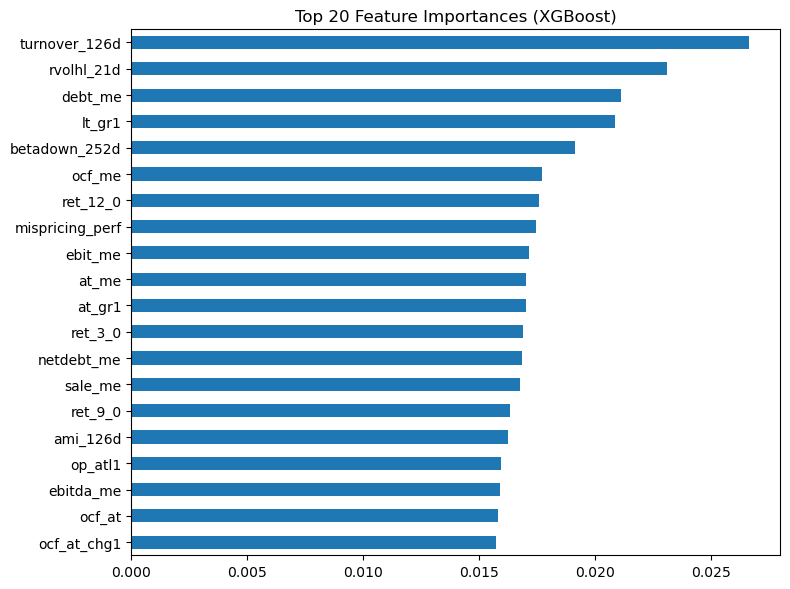


>>> Reentrenando LightGBM final (2001–2019)…
>>> Reentrenando XGB final (2001–2019)…

=== CV SUMMARY (mean ± std) ===


,RMSE,MAE,R2,Pearson,SpearmanIC,SharpeLS
LightGBM,"{'mean': 0.12147, 'std': 0.01495}","{'mean': 0.07643, 'std': 0.00936}","{'mean': -0.00653, 'std': 0.02766}","{'mean': 0.08384, 'std': 0.07351}","{'mean': 0.09378, 'std': 0.05919}","{'mean': 1.70138, 'std': 1.55373}"
XGBoost,"{'mean': 0.12151, 'std': 0.01486}","{'mean': 0.07664, 'std': 0.00935}","{'mean': -0.00743, 'std': 0.02723}","{'mean': 0.07403, 'std': 0.07712}","{'mean': 0.06701, 'std': 0.06792}","{'mean': 1.78519, 'std': 1.55986}"


In [ ]:
# ================== IMPORTS & SETUP ==================
import numpy as np
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import lightgbm as lgb
from xgboost import XGBRegressor

SEED = 42
np.random.seed(SEED)

# ================== INPUT DATA ==================
# variables_df debe existir en el entorno. Asegúrate de que 'eom' sea datetime.
variables_df['eom'] = pd.to_datetime(variables_df['eom'])

# Target y features (mantengo nombres tal cual)
TARGET = 'ret_exc_lead1m'
META_DROP = ['id', 'eom','age',TARGET] # DELETE age for directily correlation with target
# También nix_gr1a, nfna_gr1a, debt_at, fnl_gr1a, pues están altamente correlacionadas
META_DROP += ['nix_gr1a', 'nfna_gr1a', 'debt_at', 'fnl_gr1a']

X = variables_df.drop(columns=META_DROP, errors='ignore').copy()
y = variables_df[TARGET].copy()
dates = variables_df['eom'].copy()

# (Opcional) castear a float32 para evitar problemas con float16 en boosters
num_cols = X.select_dtypes(include=['float16', 'float32', 'float64', 'int32', 'int64']).columns.tolist()
X[num_cols] = X[num_cols].astype(np.float32)

# Si tuvieras columnas categóricas reales, decláralas aquí (por nombre de columna)
cat_features = []  # p.ej.: ['sector_code'] si existiera


# ================== HELPERS ==================
def month_long_short_return(df_month, pred_col, ret_col, q=0.10):
    """
    Retorno long-short por mes:
      - Long: top q por predicción
      - Short: bottom q por predicción
    Retorno mensual = mean(ret_top) - mean(ret_bottom)
    """
    n = len(df_month)
    if n < 10:
        return np.nan
    df = df_month.sort_values(pred_col).reset_index(drop=True)
    k = max(1, int(np.floor(q * n)))
    long_ret = df.iloc[-k:][ret_col].mean()
    short_ret = df.iloc[:k][ret_col].mean()
    return float(long_ret - short_ret)

def sharpe_annualized(monthly_returns):
    """
    SR anualizado = mean / std * sqrt(12)
    """
    mr = pd.Series(monthly_returns).dropna()
    if len(mr) < 2 or mr.std() == 0:
        return np.nan
    return mr.mean() / mr.std() * np.sqrt(12)

def build_walkforward_splits(eom_series,
                             train_months=120,  # 10 años
                             valid_months=12,   # 1 año
                             embargo_months=1,
                             start='2001-01-01', end='2019-12-31'):
    """
    Genera splits walk-forward por meses con embargo usando Periodos ('M').
    Evita cualquier cast a 'datetime64[M]'.
    """
    # Periodos mensuales (PeriodIndex)
    periods_all = eom_series.dt.to_period('M')

    # Rango mensual para CV (PeriodIndex)
    start_p = pd.Period(pd.Timestamp(start), freq='M')
    end_p   = pd.Period(pd.Timestamp(end),   freq='M')

    # Meses ordenados presentes en datos dentro de [start, end]
    months_all = periods_all.sort_values().unique()
    months_cv = pd.PeriodIndex([p for p in months_all if (p >= start_p and p <= end_p)], freq='M')

    splits = []
    i = 0
    # Avanza en saltos de 'valid_months' (p.ej. 12) para generar folds anuales
    while True:
        train_start_idx = i
        train_end_idx   = i + train_months - 1
        embargo_end_idx = train_end_idx + embargo_months
        valid_end_idx   = embargo_end_idx + valid_months

        if valid_end_idx >= len(months_cv):
            break

        train_month_range = months_cv[train_start_idx:train_end_idx + 1]
        valid_month_range = months_cv[embargo_end_idx + 1:valid_end_idx + 1]

        # Máscaras por comparación de Periodos (no timestamps)
        train_mask = periods_all.isin(train_month_range).values
        valid_mask = periods_all.isin(valid_month_range).values

        if train_mask.sum() >= 100 and valid_mask.sum() >= 30:
            splits.append((train_mask, valid_mask))

        i += valid_months

    return splits


# ================== CV CORE ==================
def evaluate_fold_predictions(y_valid, y_pred, d_valid, q=0.10):
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    mae  = mean_absolute_error(y_valid, y_pred)
    r2   = r2_score(y_valid, y_pred)

    if y_valid.nunique() > 1 and np.std(y_pred) > 0:
        pear = pearsonr(y_valid, y_pred)[0]
        spear = spearmanr(y_valid, y_pred)[0]
    else:
        pear, spear = np.nan, np.nan

    df_eval = pd.DataFrame({'eom': d_valid.values, 'y': y_valid.values, 'yhat': y_pred})

    ls_by_month = (
        df_eval
        .groupby(df_eval['eom'].dt.to_period('M'), group_keys=False)
        .apply(lambda g: month_long_short_return(g, 'yhat', 'y', q=q))
        .astype(float)
    )
    sr_ls = sharpe_annualized(ls_by_month.values)

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Pearson': pear,
        'SpearmanIC': spear,
        'SharpeLS': sr_ls
    }



def cross_validate_models(X, y, dates,
                          train_months=120, valid_months=12, embargo_months=1,
                          cat_features=None, seed=SEED, save_dir='models'):
    """
    Walk-forward CV para LightGBMRegressor y XGBRegressor.
    Devuelve un dataframe con mean/std de métricas por modelo.
    Guarda los modelos entrenados en el último fold y también reentrena final (2001–2019).
    """
    os.makedirs(save_dir, exist_ok=True)

    if cat_features:
        cat_features = [c for c in cat_features if c in X.columns]
    else:
        cat_features = []

    splits = build_walkforward_splits(dates,
                                      train_months=train_months,
                                      valid_months=valid_months,
                                      embargo_months=embargo_months,
                                      start='2001-01-01', end='2019-12-31')

    results = {}

    # ---------------- LIGHTGBM ----------------
    print("\n>>> Evaluando LightGBMRegressor (regression)")
    lgb_metrics = {'RMSE': [], 'MAE': [], 'R2': [], 'Pearson': [], 'SpearmanIC': [], 'SharpeLS': []}

    for fold, (train_mask, valid_mask) in enumerate(splits, 1):
        X_train, X_valid = X.loc[train_mask], X.loc[valid_mask]
        y_train, y_valid = y.loc[train_mask], y.loc[valid_mask]
        d_valid = dates.loc[valid_mask]

        model_lgb = lgb.LGBMRegressor(
            objective='regression',
            boosting_type='gbdt',
            random_state=seed,
            n_estimators=2000,
            learning_rate=0.03,
            subsample=0.8,
            colsample_bytree=0.8,
            num_leaves=64,
            reg_alpha=0.0,
            reg_lambda=0.0,
            # silenciar logs desde el constructor (no en fit)
            verbosity=-1
        )

        # IMPORTANTE: no uses 'verbose' en fit; usa callbacks
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0)  # 0 = sin logs
        ]

        model_lgb.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='l2',
            categorical_feature=cat_features if len(cat_features) else 'auto',
            callbacks=callbacks
        )

        y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)

        fold_metrics = evaluate_fold_predictions(y_valid, y_pred, d_valid, q=0.10)
        for k, v in fold_metrics.items():
            lgb_metrics[k].append(v)

        print(f"[LGB Fold {fold}] "
              f"RMSE={fold_metrics['RMSE']:.5f} | MAE={fold_metrics['MAE']:.5f} | R2={fold_metrics['R2']:.3f} | "
              f"ρ={fold_metrics['Pearson']:.3f} | IC={fold_metrics['SpearmanIC']:.3f} | SR(LS)={fold_metrics['SharpeLS']:.3f}")

    results['LightGBM'] = {m: (np.nanmean(v), np.nanstd(v)) for m, v in lgb_metrics.items()}

    # Importancias (último fold)
    importances = pd.Series(model_lgb.feature_importances_, index=model_lgb.feature_name_)
    top_features = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    top_features.sort_values().plot(kind='barh')
    plt.title("Top 20 Feature Importances (LightGBM)")
    plt.tight_layout()
    plt.show()

    # Guarda último modelo del CV (opcional)
    joblib.dump(model_lgb, os.path.join(save_dir, 'lightgbm_reg_lastfold.pkl'))

    # ---------------- XGBOOST ----------------
    print("\n>>> Evaluando XGBRegressor (regression)")
    xgb_metrics = {'RMSE': [], 'MAE': [], 'R2': [], 'Pearson': [], 'SpearmanIC': [], 'SharpeLS': []}

    for fold, (train_mask, valid_mask) in enumerate(splits, 1):
        X_train, X_valid = X.loc[train_mask], X.loc[valid_mask]
        y_train, y_valid = y.loc[train_mask], y.loc[valid_mask]
        d_valid = dates.loc[valid_mask]

        model_xgb = XGBRegressor(
            random_state=seed,
            n_estimators=3000,
            eval_metric='rmse',
            learning_rate=0.03,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            reg_alpha=0.0,
            early_stopping_rounds=150,
            reg_lambda=0.0,
            verbosity=0,       # silencia logs
        )

        model_xgb.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )

        y_pred = model_xgb.predict(X_valid)

        fold_metrics = evaluate_fold_predictions(y_valid, y_pred, d_valid, q=0.10)
        for k, v in fold_metrics.items():
            xgb_metrics[k].append(v)

        print(f"[XGB Fold {fold}] "
              f"RMSE={fold_metrics['RMSE']:.5f} | MAE={fold_metrics['MAE']:.5f} | R2={fold_metrics['R2']:.3f} | "
              f"ρ={fold_metrics['Pearson']:.3f} | IC={fold_metrics['SpearmanIC']:.3f} | SR(LS)={fold_metrics['SharpeLS']:.3f}")

    results['XGBoost'] = {m: (np.nanmean(v), np.nanstd(v)) for m, v in xgb_metrics.items()}

    # Importancias (último fold)
    importances = pd.Series(model_xgb.feature_importances_, index=X.columns)
    top_features = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    top_features.sort_values().plot(kind='barh')
    plt.title("Top 20 Feature Importances (XGBoost)")
    plt.tight_layout()
    plt.show()

    # Guarda último modelo del CV (opcional)
    joblib.dump(model_xgb, os.path.join(save_dir, 'xgb_reg_lastfold.pkl'))

    # ---------------- RESUMEN DE MÉTRICAS ----------------
    res_df = (pd.DataFrame(results)
                .applymap(lambda m: {'mean': round(m[0], 5), 'std': round(m[1], 5)})
                .T)

    # ---------------- ENTRENAMIENTO FINAL 2001–2019 ----------------
    # Para enviar a kaggle
    mask_full_train = (dates >= pd.Timestamp('2001-01-01')) & (dates <= pd.Timestamp('2019-12-31'))
    X_full, y_full = X.loc[mask_full_train], y.loc[mask_full_train]

    print("\n>>> Reentrenando LightGBM final (2001–2019)…")
    model_lgb_final = lgb.LGBMRegressor(
        objective='regression',
        boosting_type='gbdt',
        random_state=seed,
        n_estimators= int(np.mean([2000, getattr(model_lgb, 'best_iteration_', 2000)])),  # heurística simple
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        num_leaves=64,
        verbosity=-1
    )
    model_lgb_final.fit(X_full, y_full, categorical_feature=cat_features if len(cat_features) else 'auto')
    joblib.dump(model_lgb_final, os.path.join(save_dir, 'lightgbm_reg_final_2001_2019.pkl'))

    print(">>> Reentrenando XGB final (2001–2019)…")
    model_xgb_final = XGBRegressor(
        random_state=seed,
        n_estimators=int(np.mean([3000, getattr(model_xgb, 'best_iteration', 3000)])),
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        verbosity=0
    )
    model_xgb_final.fit(X_full, y_full, verbose=False)
    joblib.dump(model_xgb_final, os.path.join(save_dir, 'xgb_reg_final_2001_2019.pkl'))

    return res_df


# ================== RUN CV ==================
cv_summary = cross_validate_models(
    X=X, y=y, dates=dates,
    train_months=120, valid_months=12, embargo_months=1,
    cat_features=None, seed=SEED, save_dir='models'
)
print("\n=== CV SUMMARY (mean ± std) ===")
display(cv_summary)



>>> Evaluando LightGBMRegressor (regression)
[LGB Fold 1] RMSE=0.13284 | MAE=0.09365 | R2=-0.004 | ρ=0.106 | IC=0.131 | SR(LS)=1.449
[LGB Fold 2] RMSE=0.12296 | MAE=0.08194 | R2=0.000 | ρ=0.074 | IC=0.097 | SR(LS)=1.552
[LGB Fold 3] RMSE=0.13898 | MAE=0.08191 | R2=-0.056 | ρ=-0.038 | IC=0.003 | SR(LS)=-0.390
[LGB Fold 4] RMSE=0.12759 | MAE=0.07546 | R2=0.041 | ρ=0.229 | IC=0.208 | SR(LS)=4.644


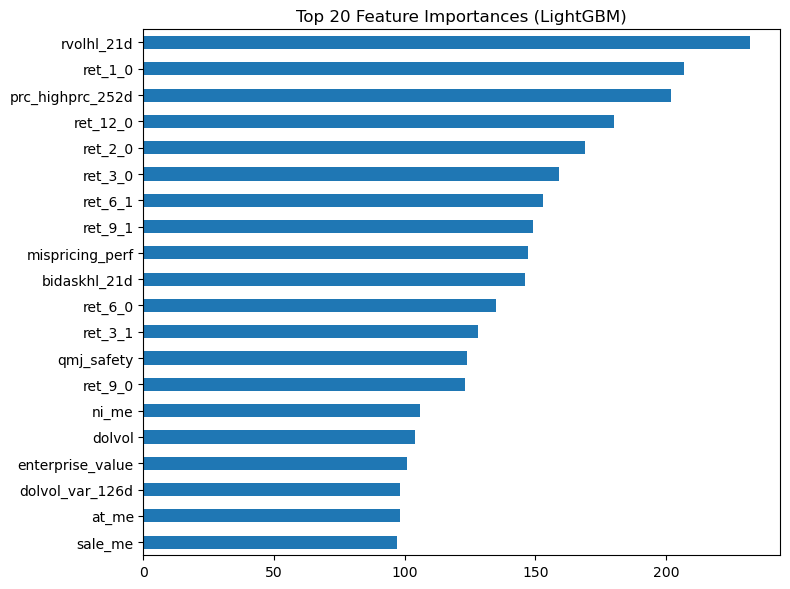


>>> Evaluando XGBRegressor (regression)
[XGB Fold 1] RMSE=0.13351 | MAE=0.09446 | R2=-0.014 | ρ=0.077 | IC=0.104 | SR(LS)=0.973
[XGB Fold 2] RMSE=0.12315 | MAE=0.08214 | R2=-0.003 | ρ=0.023 | IC=-0.004 | SR(LS)=1.899
[XGB Fold 3] RMSE=0.13809 | MAE=0.08109 | R2=-0.043 | ρ=0.060 | IC=0.056 | SR(LS)=2.079
[XGB Fold 4] RMSE=0.12713 | MAE=0.07572 | R2=0.048 | ρ=0.242 | IC=0.214 | SR(LS)=5.422


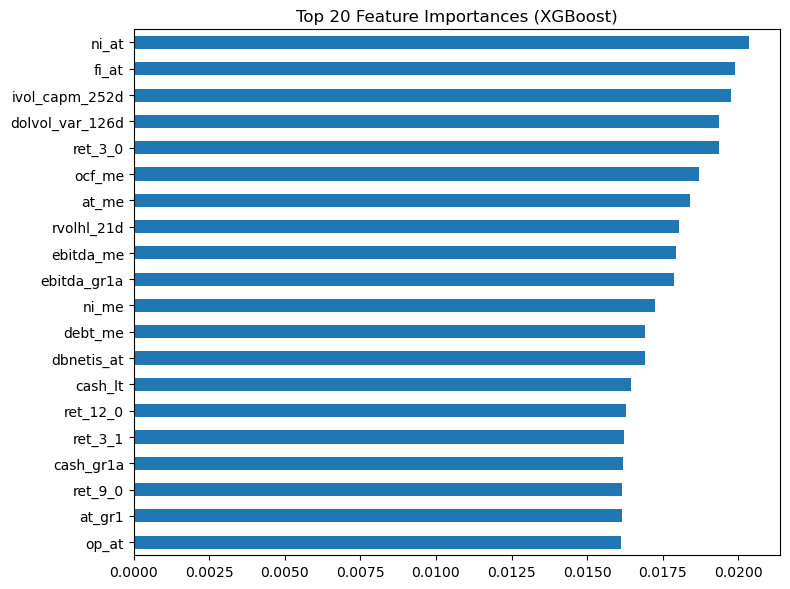


>>> Reentrenando LightGBM final (2001–2019)…
>>> Reentrenando XGB final (2001–2019)…

=== CV SUMMARY (mean ± std) ===


,RMSE,MAE,R2,Pearson,SpearmanIC,SharpeLS
LightGBM,"{'mean': 0.13059, 'std': 0.00597}","{'mean': 0.08324, 'std': 0.00656}","{'mean': -0.00459, 'std': 0.03459}","{'mean': 0.09285, 'std': 0.09515}","{'mean': 0.10999, 'std': 0.07349}","{'mean': 1.81366, 'std': 1.80765}"
XGBoost,"{'mean': 0.13047, 'std': 0.00574}","{'mean': 0.08335, 'std': 0.00686}","{'mean': -0.00283, 'std': 0.03286}","{'mean': 0.10088, 'std': 0.08397}","{'mean': 0.09247, 'std': 0.08025}","{'mean': 2.59318, 'std': 1.68654}"


In [30]:
# ================== IMPORTS & SETUP ==================
import numpy as np
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import lightgbm as lgb
from xgboost import XGBRegressor

SEED = 42
np.random.seed(SEED)

# ================== INPUT DATA ==================
# variables_df debe existir en el entorno. Asegúrate de que 'eom' sea datetime.
variables_df['eom'] = pd.to_datetime(variables_df['eom'])

# Target y features (mantengo nombres tal cual)
TARGET = 'ret_exc_lead1m'
META_DROP = ['id', 'eom', 'age', TARGET]  # DELETE age por alta correlación con el target
# También nix_gr1a, nfna_gr1a, debt_at, fnl_gr1a, pues están altamente correlacionadas
META_DROP += ['nix_gr1a', 'nfna_gr1a', 'debt_at', 'fnl_gr1a']

X = variables_df.drop(columns=META_DROP, errors='ignore').copy()
y = variables_df[TARGET].copy()
dates = variables_df['eom'].copy()

# (Opcional) castear a float32 para evitar problemas con float16 en boosters
num_cols = X.select_dtypes(include=['float16', 'float32', 'float64', 'int32', 'int64']).columns.tolist()
X[num_cols] = X[num_cols].astype(np.float32)

# Si tuvieras columnas categóricas reales, decláralas aquí (por nombre de columna)
cat_features = []  # p.ej.: ['sector_code'] si existiera

# ================== CONFIG ADICIONAL ==================
# Métrica para elegir "mejor fold"
BEST_METRIC = 'SpearmanIC'  # opciones: 'SpearmanIC' | 'SharpeLS' | 'Pearson' | 'R2' | etc.
MAX_VALID_YEAR = 2015       # límite superior del año de validación


# ================== HELPERS ==================
def month_long_short_return(df_month, pred_col, ret_col, q=0.10):
    """
    Retorno long-short por mes:
      - Long: top q por predicción
      - Short: bottom q por predicción
    Retorno mensual = mean(ret_top) - mean(ret_bottom)
    """
    n = len(df_month)
    if n < 10:
        return np.nan
    df = df_month.sort_values(pred_col).reset_index(drop=True)
    k = max(1, int(np.floor(q * n)))
    long_ret = df.iloc[-k:][ret_col].mean()
    short_ret = df.iloc[:k][ret_col].mean()
    return float(long_ret - short_ret)

def sharpe_annualized(monthly_returns):
    """
    SR anualizado = mean / std * sqrt(12)
    """
    mr = pd.Series(monthly_returns).dropna()
    if len(mr) < 2 or mr.std() == 0:
        return np.nan
    return mr.mean() / mr.std() * np.sqrt(12)

def build_walkforward_splits(eom_series,
                             train_months=120,  # 10 años
                             valid_months=12,   # 1 año
                             embargo_months=1,
                             start='2001-01-01', end='2019-12-31',
                             max_valid_year=None):
    """
    Genera splits walk-forward por meses con embargo usando Periodos ('M').
    Evita cualquier cast a 'datetime64[M]'.
    Si max_valid_year no es None, sólo devuelve folds cuyo último mes de validación
    tiene año <= max_valid_year.
    """
    # Periodos mensuales (PeriodIndex)
    periods_all = eom_series.dt.to_period('M')

    # Rango mensual para CV (PeriodIndex)
    start_p = pd.Period(pd.Timestamp(start), freq='M')
    end_p   = pd.Period(pd.Timestamp(end),   freq='M')

    # Meses ordenados presentes en datos dentro de [start, end]
    months_all = periods_all.sort_values().unique()
    months_cv = pd.PeriodIndex([p for p in months_all if (p >= start_p and p <= end_p)], freq='M')

    splits = []
    i = 0
    # Avanza en saltos de 'valid_months' (p.ej. 12) para generar folds anuales
    while True:
        train_start_idx = i
        train_end_idx   = i + train_months - 1
        embargo_end_idx = train_end_idx + embargo_months
        valid_end_idx   = embargo_end_idx + valid_months

        if valid_end_idx >= len(months_cv):
            break

        train_month_range = months_cv[train_start_idx:train_end_idx + 1]
        valid_month_range = months_cv[embargo_end_idx + 1:valid_end_idx + 1]

        # filtro por año de validación máximo (si se pide)
        if max_valid_year is not None and valid_month_range[-1].year > max_valid_year:
            break  # a partir de aquí las validaciones serán posteriores

        # Máscaras por comparación de Periodos (no timestamps)
        train_mask = periods_all.isin(train_month_range).values
        valid_mask = periods_all.isin(valid_month_range).values

        if train_mask.sum() >= 100 and valid_mask.sum() >= 30:
            splits.append((train_mask, valid_mask))

        i += valid_months

    return splits


# ================== CV CORE ==================
def evaluate_fold_predictions(y_valid, y_pred, d_valid, q=0.10):
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    mae  = mean_absolute_error(y_valid, y_pred)
    r2   = r2_score(y_valid, y_pred)

    if y_valid.nunique() > 1 and np.std(y_pred) > 0:
        pear = pearsonr(y_valid, y_pred)[0]
        spear = spearmanr(y_valid, y_pred)[0]
    else:
        pear, spear = np.nan, np.nan

    df_eval = pd.DataFrame({'eom': d_valid.values, 'y': y_valid.values, 'yhat': y_pred})

    ls_by_month = (
        df_eval
        .groupby(df_eval['eom'].dt.to_period('M'), group_keys=False)
        .apply(lambda g: month_long_short_return(g, 'yhat', 'y', q=q))
        .astype(float)
    )
    sr_ls = sharpe_annualized(ls_by_month.values)

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Pearson': pear,
        'SpearmanIC': spear,
        'SharpeLS': sr_ls
    }


def cross_validate_models(X, y, dates,
                          train_months=120, valid_months=12, embargo_months=1,
                          cat_features=None, seed=SEED, save_dir='models'):
    """
    Walk-forward CV para LightGBMRegressor y XGBRegressor.
    Devuelve un dataframe con mean/std de métricas por modelo.
    Guarda:
      - último fold (dentro del subconjunto cuyo año de validación <= 2015)
      - mejor fold (por BEST_METRIC) de ese mismo subconjunto
    Reentrena final (2001–2019) igual que tu versión original.
    """
    os.makedirs(save_dir, exist_ok=True)

    if cat_features:
        cat_features = [c for c in cat_features if c in X.columns]
    else:
        cat_features = []

    # >>>>> único cambio funcional: limitar a validaciones hasta 2015
    splits = build_walkforward_splits(
        dates,
        train_months=train_months,
        valid_months=valid_months,
        embargo_months=embargo_months,
        start='2001-01-01',
        end='2019-12-31',
        max_valid_year=MAX_VALID_YEAR,   # <-- límite
    )

    results = {}

    # ---------------- LIGHTGBM ----------------
    print("\n>>> Evaluando LightGBMRegressor (regression)")
    lgb_metrics = {'RMSE': [], 'MAE': [], 'R2': [], 'Pearson': [], 'SpearmanIC': [], 'SharpeLS': []}

    best_metric_val_lgb = -np.inf
    best_model_lgb = None
    last_model_lgb = None

    for fold, (train_mask, valid_mask) in enumerate(splits, 1):
        X_train, X_valid = X.loc[train_mask], X.loc[valid_mask]
        y_train, y_valid = y.loc[train_mask], y.loc[valid_mask]
        d_valid = dates.loc[valid_mask]

        model_lgb = lgb.LGBMRegressor(
            objective='regression',
            boosting_type='gbdt',
            random_state=seed,
            n_estimators=2000,
            learning_rate=0.03,
            subsample=0.8,
            colsample_bytree=0.8,
            num_leaves=64,
            reg_alpha=0.0,
            reg_lambda=0.0,
            verbosity=-1
        )

        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=0)
        ]

        model_lgb.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='l2',
            categorical_feature=cat_features if len(cat_features) else 'auto',
            callbacks=callbacks
        )

        y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)

        fold_metrics = evaluate_fold_predictions(y_valid, y_pred, d_valid, q=0.10)
        for k, v in fold_metrics.items():
            lgb_metrics[k].append(v)

        print(f"[LGB Fold {fold}] "
              f"RMSE={fold_metrics['RMSE']:.5f} | MAE={fold_metrics['MAE']:.5f} | R2={fold_metrics['R2']:.3f} | "
              f"ρ={fold_metrics['Pearson']:.3f} | IC={fold_metrics['SpearmanIC']:.3f} | SR(LS)={fold_metrics['SharpeLS']:.3f}")

        # --- tracking best fold (por BEST_METRIC) y last fold ---
        metric_val = fold_metrics[BEST_METRIC]
        if (metric_val is not None) and (not np.isnan(metric_val)) and (metric_val > best_metric_val_lgb):
            best_metric_val_lgb = metric_val
            best_model_lgb = model_lgb
        last_model_lgb = model_lgb

    results['LightGBM'] = {m: (np.nanmean(v), np.nanstd(v)) for m, v in lgb_metrics.items()}

    # Importancias (último fold) -> igual que tu pipeline original
    importances = pd.Series(last_model_lgb.feature_importances_, index=last_model_lgb.feature_name_)
    top_features = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    top_features.sort_values().plot(kind='barh')
    plt.title("Top 20 Feature Importances (LightGBM)")
    plt.tight_layout()
    plt.show()

    # Guarda modelos LGB
    joblib.dump(last_model_lgb, os.path.join(save_dir, 'lightgbm_reg_lastfold.pkl'))
    if best_model_lgb is not None:
        joblib.dump(best_model_lgb, os.path.join(save_dir, 'lightgbm_reg_bestfold.pkl'))

    # ---------------- XGBOOST ----------------
    print("\n>>> Evaluando XGBRegressor (regression)")
    xgb_metrics = {'RMSE': [], 'MAE': [], 'R2': [], 'Pearson': [], 'SpearmanIC': [], 'SharpeLS': []}

    best_metric_val_xgb = -np.inf
    best_model_xgb = None
    last_model_xgb = None

    for fold, (train_mask, valid_mask) in enumerate(splits, 1):
        X_train, X_valid = X.loc[train_mask], X.loc[valid_mask]
        y_train, y_valid = y.loc[train_mask], y.loc[valid_mask]
        d_valid = dates.loc[valid_mask]

        model_xgb = XGBRegressor(
            random_state=seed,
            n_estimators=3000,
            eval_metric='rmse',
            learning_rate=0.03,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            reg_alpha=0.0,
            early_stopping_rounds=150,
            reg_lambda=0.0,
            verbosity=0,
        )

        model_xgb.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )

        y_pred = model_xgb.predict(X_valid)

        fold_metrics = evaluate_fold_predictions(y_valid, y_pred, d_valid, q=0.10)
        for k, v in fold_metrics.items():
            xgb_metrics[k].append(v)

        print(f"[XGB Fold {fold}] "
              f"RMSE={fold_metrics['RMSE']:.5f} | MAE={fold_metrics['MAE']:.5f} | R2={fold_metrics['R2']:.3f} | "
              f"ρ={fold_metrics['Pearson']:.3f} | IC={fold_metrics['SpearmanIC']:.3f} | SR(LS)={fold_metrics['SharpeLS']:.3f}")

        metric_val = fold_metrics[BEST_METRIC]
        if (metric_val is not None) and (not np.isnan(metric_val)) and (metric_val > best_metric_val_xgb):
            best_metric_val_xgb = metric_val
            best_model_xgb = model_xgb
        last_model_xgb = model_xgb

    results['XGBoost'] = {m: (np.nanmean(v), np.nanstd(v)) for m, v in xgb_metrics.items()}

    # Importancias (último fold) -> igual que tu pipeline original
    importances = pd.Series(last_model_xgb.feature_importances_, index=X.columns)
    top_features = importances.sort_values(ascending=False).head(20)
    plt.figure(figsize=(8,6))
    top_features.sort_values().plot(kind='barh')
    plt.title("Top 20 Feature Importances (XGBoost)")
    plt.tight_layout()
    plt.show()

    # Guarda modelos XGB
    joblib.dump(last_model_xgb, os.path.join(save_dir, 'xgb_reg_lastfold.pkl'))
    if best_model_xgb is not None:
        joblib.dump(best_model_xgb, os.path.join(save_dir, 'xgb_reg_bestfold.pkl'))

    # ---------------- RESUMEN DE MÉTRICAS ----------------
    res_df = (pd.DataFrame(results)
                .applymap(lambda m: {'mean': round(m[0], 5), 'std': round(m[1], 5)})
                .T)

    # ---------------- ENTRENAMIENTO FINAL 2001–2019 ----------------
    # Para enviar a kaggle
    mask_full_train = (dates >= pd.Timestamp('2001-01-01')) & (dates <= pd.Timestamp('2019-12-31'))
    X_full, y_full = X.loc[mask_full_train], y.loc[mask_full_train]

    print("\n>>> Reentrenando LightGBM final (2001–2019)…")
    model_lgb_final = lgb.LGBMRegressor(
        objective='regression',
        boosting_type='gbdt',
        random_state=seed,
        n_estimators=int(np.mean([2000, getattr(last_model_lgb, 'best_iteration_', 2000)])),  # misma heurística
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        num_leaves=64,
        verbosity=-1
    )
    model_lgb_final.fit(X_full, y_full, categorical_feature=cat_features if len(cat_features) else 'auto')
    joblib.dump(model_lgb_final, os.path.join(save_dir, 'lightgbm_reg_final_2001_2019.pkl'))

    print(">>> Reentrenando XGB final (2001–2019)…")
    model_xgb_final = XGBRegressor(
        random_state=seed,
        n_estimators=int(np.mean([3000, getattr(last_model_xgb, 'best_iteration', 3000)])),
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        verbosity=0
    )
    model_xgb_final.fit(X_full, y_full, verbose=False)
    joblib.dump(model_xgb_final, os.path.join(save_dir, 'xgb_reg_final_2001_2019.pkl'))

    return res_df


# ================== RUN CV ==================
cv_summary = cross_validate_models(
    X=X, y=y, dates=dates,
    train_months=120, valid_months=12, embargo_months=1,
    cat_features=None, seed=SEED, save_dir='models'
)
print("\n=== CV SUMMARY (mean ± std) ===")
display(cv_summary)


## **EVALUATION**

Pseudo test

In [21]:
# 1) Reentrenar modelos SOLO con 2001–2014
cutoff = pd.Timestamp('2014-12-31')
mask_train = (dates >= pd.Timestamp('2001-01-01')) & (dates <= cutoff)
X_train_oos, y_train_oos = X.loc[mask_train], y.loc[mask_train]

mdl_lgb_oos = lgb.LGBMRegressor(
    objective='regression', boosting_type='gbdt',
    random_state=SEED, n_estimators=2000, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.8, num_leaves=64, verbosity=-1
).fit(X_train_oos, y_train_oos)

mdl_xgb_oos = XGBRegressor(
    random_state=SEED, n_estimators=3000, learning_rate=0.03,
    max_depth=6, subsample=0.8, colsample_bytree=0.8, tree_method="hist", verbosity=0
).fit(X_train_oos, y_train_oos)

joblib.dump(mdl_lgb_oos, 'models/lightgbm_reg_pseudofinal_2001_2014.pkl')
joblib.dump(mdl_xgb_oos, 'models/xgb_reg_pseudofinal_2001_2014.pkl')

# 2) Inferencia SOLO 2015–2019 con esos modelos
infer_start, infer_end = pd.Timestamp('2015-01-01'), pd.Timestamp('2019-12-31')
mask_inf = (dates >= infer_start) & (dates <= infer_end)
X_inf, y_inf, d_inf = X.loc[mask_inf], y.loc[mask_inf], dates.loc[mask_inf]

mdl_lgb = joblib.load('models/lightgbm_reg_pseudofinal_2001_2014.pkl')
mdl_xgb = joblib.load('models/xgb_reg_pseudofinal_2001_2014.pkl')

yhat_lgb = mdl_lgb.predict(X_inf)
yhat_xgb = mdl_xgb.predict(X_inf)

Inference


=== INFERENCE (2015-01-01 to 2019-12-31) ===
LightGBM  -> IC_mean=0.060 (±0.114) | SR(LS)=1.395
XGBoost   -> IC_mean=0.052 (±0.104) | SR(LS)=1.252
EnsembleR -> IC_mean=0.058 (±0.111) | SR(LS)=1.677


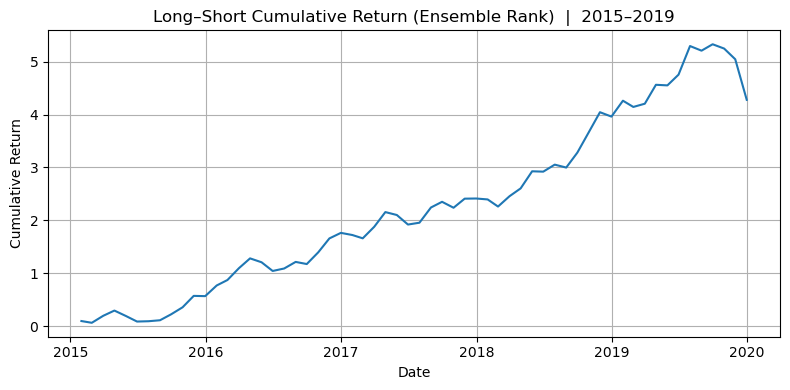

            IC_ens  LS_ens
2015-01-31   0.322   0.095
2015-02-28  -0.002  -0.030
2015-03-31  -0.186   0.125
2015-04-30   0.180   0.082
2015-05-31  -0.201  -0.079
2015-06-30   0.216  -0.088
2015-07-31  -0.113   0.005
2015-08-31   0.045   0.017
2015-09-30   0.124   0.101
2015-10-31   0.191   0.109
2015-11-30   0.106   0.159
2015-12-31   0.086  -0.003


In [34]:
# ================== INFERENCE & EVALUATION ==================
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# --- Reutilizamos tus helpers ---
def month_long_short_return(df_month, pred_col, ret_col, q=0.10):
    n = len(df_month)
    if n < 10:
        return np.nan
    df = df_month.sort_values(pred_col).reset_index(drop=True)
    k = max(1, int(np.floor(q * n)))
    long_ret = df.iloc[-k:][ret_col].mean()
    short_ret = df.iloc[:k][ret_col].mean()
    return float(long_ret - short_ret)

def sharpe_annualized(monthly_returns):
    mr = pd.Series(monthly_returns).dropna()
    if len(mr) < 2 or mr.std() == 0:
        return np.nan
    return mr.mean() / mr.std() * np.sqrt(12)

def evaluate_predictions_frame(df_pred, pred_col='yhat', ret_col='y', date_col='eom', q=0.10):
    # IC por mes
    ic_by_month = (
        df_pred.groupby(df_pred[date_col].dt.to_period('M'))
               .apply(lambda g: spearmanr(g[ret_col], g[pred_col])[0])
               .astype(float)
    )
    # Long–short por mes
    ls_by_month = (
        df_pred.groupby(df_pred[date_col].dt.to_period('M'))
               .apply(lambda g: month_long_short_return(g, pred_col, ret_col, q=q))
               .astype(float)
    )
    sr_ls = sharpe_annualized(ls_by_month.values)

    out = {
        'IC_mean': float(np.nanmean(ic_by_month)),
        'IC_std':  float(np.nanstd(ic_by_month)),
        'SR_LS':   float(sr_ls),
        'months':  ic_by_month.index.astype(str).tolist(),
        'IC_series': ic_by_month.values,
        'LS_series': ls_by_month.values,
    }
    return out

def make_features_view(variables_df, META_DROP):
    X_inf = variables_df.drop(columns=META_DROP, errors='ignore').copy()
    # asegurar dtypes numéricos compatibles
    num_cols = X_inf.select_dtypes(include=['float16','float32','float64','int32','int64']).columns
    X_inf[num_cols] = X_inf[num_cols].astype(np.float32)
    return X_inf

# === Configura tu pseudo-test (cámbialo si quieres otro rango) ===
infer_start = pd.Timestamp('2015-01-01')
infer_end   = pd.Timestamp('2019-12-31')

mask_inf = (variables_df['eom'] >= infer_start) & (variables_df['eom'] <= infer_end)
df_inf = variables_df.loc[mask_inf].copy()

TARGET = 'ret_exc_lead1m'
META_DROP = ['id','eom','age',TARGET,'nix_gr1a','nfna_gr1a','debt_at','fnl_gr1a']

X_inf = make_features_view(df_inf, META_DROP)
y_inf = df_inf[TARGET].astype(float)
d_inf = df_inf['eom']

# === Carga modelos finales entrenados 2001–2019 ===
mdl_lgb = joblib.load('models/lightgbm_reg_bestfold.pkl')
mdl_xgb = joblib.load('models/xgb_reg_bestfold.pkl')

#mdl_lgb = joblib.load('models/lightgbm_reg_lastfold.pkl') # models/lightgbm_reg_pesudofinal_2001_2014.pkl
#mdl_xgb = joblib.load('models/xgb_reg_lastfold.pkl') # models/xgb_reg_pesudofinal_2001_2014.pkl

#mdl_xgb = joblib.load('models/xgb_reg_pseudofinal_2001_2014.pkl')
#mdl_lgb = joblib.load('models/lightgbm_reg_pseudofinal_2001_2014.pkl')

# === Predicciones individuales ===
yhat_lgb = pd.Series(mdl_lgb.predict(X_inf), index=X_inf.index, name='yhat_lgb')
yhat_xgb = pd.Series(mdl_xgb.predict(X_inf), index=X_inf.index, name='yhat_xgb')

# === DataFrame de evaluación base ===
df_pred = pd.DataFrame({
    'eom': d_inf.values,
    'y': y_inf.values,
    'yhat_lgb': yhat_lgb.values,
    'yhat_xgb': yhat_xgb.values
}, index=X_inf.index)

# === Ensemble por rank mensual (promedia ranks de cada modelo) ===
def rank_0_1(s):
    return s.rank(pct=True)

df_pred['rank_lgb'] = df_pred.groupby(df_pred['eom'].dt.to_period('M'))['yhat_lgb'].transform(rank_0_1)
df_pred['rank_xgb'] = df_pred.groupby(df_pred['eom'].dt.to_period('M'))['yhat_xgb'].transform(rank_0_1)
df_pred['yhat_ens_rank'] = 0.5*df_pred['rank_lgb'] + 0.5*df_pred['rank_xgb']

# === Métricas por modelo y ensemble ===
res_lgb = evaluate_predictions_frame(df_pred.rename(columns={'yhat_lgb':'yhat'}), pred_col='yhat', ret_col='y', date_col='eom', q=0.10)
res_xgb = evaluate_predictions_frame(df_pred.rename(columns={'yhat_xgb':'yhat'}), pred_col='yhat', ret_col='y', date_col='eom', q=0.10)
res_ens = evaluate_predictions_frame(df_pred.rename(columns={'yhat_ens_rank':'yhat'}), pred_col='yhat', ret_col='y', date_col='eom', q=0.10)

print("\n=== INFERENCE ({} to {}) ===".format(infer_start.date(), infer_end.date()))
print("LightGBM  -> IC_mean={:.3f} (±{:.3f}) | SR(LS)={:.3f}".format(res_lgb['IC_mean'], res_lgb['IC_std'], res_lgb['SR_LS']))
print("XGBoost   -> IC_mean={:.3f} (±{:.3f}) | SR(LS)={:.3f}".format(res_xgb['IC_mean'], res_xgb['IC_std'], res_xgb['SR_LS']))
print("EnsembleR -> IC_mean={:.3f} (±{:.3f}) | SR(LS)={:.3f}".format(res_ens['IC_mean'], res_ens['IC_std'], res_ens['SR_LS']))

# === Curva de retorno acumulado long–short (ensemble) ===
ls_series = pd.Series(res_ens['LS_series'], index=pd.PeriodIndex(res_ens['months'], freq='M').to_timestamp('M'))
cumret = (1 + ls_series).cumprod() - 1

plt.figure(figsize=(8,4))
plt.plot(cumret.index, cumret.values)
plt.title('Long–Short Cumulative Return (Ensemble Rank)  |  {}–{}'.format(infer_start.year, infer_end.year))
plt.xlabel('Date'); plt.ylabel('Cumulative Return')
plt.grid(True); plt.tight_layout(); plt.show()

# === (Opcional) Tabla mensual con IC y LS (ensemble) ===

## objetivo del ensemble:
# El ensemble (promedio de ranks) mejora la estabilidad y reducir la varianza mensual del retorno y evita señales falsas extremas.
infer_table = pd.DataFrame({
    'IC_ens': res_ens['IC_series'],
    'LS_ens': res_ens['LS_series']
}, index=pd.PeriodIndex(res_ens['months'], freq='M').to_timestamp('M')).round(4)
print(infer_table.head(12))


En la evaluación fuera de muestra (2015–2019) los modelos presentan un IC promedio de 0.03–0.04 y un Sharpe ratio entre 1.1 y 1.3, lo cual indica una capacidad de ordenamiento útil pero limitada para explicar retornos mensuales. Estos resultados son consistentes con la literatura, donde los factores cross-sectional muestran bajo poder predictivo individual, pero su combinación mejora la estabilidad y la rentabilidad riesgo-ajustada

## **Future work**

1. Manejo de outliers, quitarlos en base al rango intercuartill (podría ser el criterio Q1 - 0.75 * IQR y Q3 + 1.5 * IQR), para ello recomiendo gráficos de dispersión frente al target (son demasiadas, aprox 70 después de descartar como 5 y no tener en cuenta el id, target y el age, pues es muy constante y está muy correlacionada). \
2. El PCA permitirá capturar las direcciones de mayor varianza en el espacio de características mediante los valores y vectores propios de la matriz de covarianzas. De esta forma, se conservará la estructura esencial de los datos reduciendo dimensionalidad, lo que puede mejorar la estabilidad del modelo sin sacrificar desempeño predictivo.
Además, la interpretación de los loadings de los componentes ayudará a identificar grupos de variables con alta correlación entre sí, lo cual puede servir para una futura selección manual o jerárquica de features. Además, con este cálculo podremos reducir la dimensionalidad de nuestros features, sin perder tanto performance.
3. Feature engineering aplicado a ventas, para ello requeriría mayor contexto del dataset, usualmente en sectores de banca, retail, ventas, la mayor información está en las variables temporales, trabjar con ventanas de tiempo, donde los patrones sean estacionales, pues si la data es completamente aleatoria sería imposible de predecir, una solución es intervalizar estos periodos, ¿cómo? mediante funciones sinusoidales, que función mediante períodos, como el sin y el cos. De esta manera, además de normalizar el dato, logramos que se comporte estacionalmente y se hace predecible. Por otro lado, pueden haber datos sueltos, en este caso por suerte no, pero esos datos "vacíos" malogran nuestro modelo, una manera de manejarlos es mediante interpolación, pero no una interpaloción lineal o bilineal (difícilmente los comportamientos son lineales), usar técnicas que interpolen con patrones no lineales. Estas mejoras permitirán aumentar la estabilidad y generalización del modelo, especialmente bajo entornos de alta varianza y ruido, característicos de datos financieros.